In [1]:
import os, sys
sys.path.append('..') # Parent directory in path
from time import time, sleep
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import statsmodels.api as sm

pd.set_option("display.precision", 4)
#import pandas_market_calendars as mcal # NYSE Calendar

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rc("font", **{"size": 14})
plt.rc("figure", **{"figsize": (16,10)})
# import matplotlib.pylab as pl
from matplotlib import cm

# 1. base data
Daily S&P 500 options data and basic features.

In [2]:
# Import data from methodology_rates_iv
base_data = pd.concat([pd.read_hdf(os.path.join("data", "spx_iv_db_1.h5")), 
                 pd.read_hdf(os.path.join("data", "spx_iv_db_2.h5"))])
base_data.head()

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK
0,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0823,0.0852,0.0882
1,2017-07-03,2017-07-21,2430,P,19.9,20.50,21.1,281,6410,2429.01,0.99,0,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0824,0.0852,0.0879
2,2017-07-03,2017-07-21,2425,P,18.0,18.50,19.0,373,38136,2429.01,4.01,1,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0854,0.0877,0.0900
3,2017-07-03,2017-07-21,2425,C,19.4,20.05,20.7,194,42228,2429.01,4.01,1,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0848,0.0878,0.0908
4,2017-07-03,2017-07-21,2435,P,22.2,22.80,23.4,394,8399,2429.01,5.99,2,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0802,0.0830,0.0858


In [4]:
raw_data = pd.concat([pd.read_hdf(os.path.join("data", "vol1.h5")), 
                 pd.read_hdf(os.path.join("data", "vol2.h5"))])
raw_data

,VOLUME,OPEN_INT,UNDERLYING_PRICE,BID_CLOSE,ASK_CLOSE,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA,STRIKE,EXP,TYPE,PRICE,TS
0,0,27.0,2429.01,398.4,404.2,0.0730,1.0000,0.0000,-0.0724,0.0000,2025.0,2017-07-21,C,2429.01,2017-07-03
1,0,0.0,2429.01,393.4,399.2,0.0730,1.0000,0.0000,-0.0726,0.0000,2030.0,2017-07-21,C,2429.01,2017-07-03
2,0,0.0,2429.01,388.4,394.2,0.0730,1.0000,0.0000,-0.0728,0.0000,2035.0,2017-07-21,C,2429.01,2017-07-03
3,0,1.0,2429.01,383.4,389.2,0.0730,1.0000,0.0000,-0.0730,0.0000,2040.0,2017-07-21,C,2429.01,2017-07-03
4,0,6.0,2429.01,378.4,384.3,0.0730,1.0000,0.0000,-0.0732,0.0000,2045.0,2017-07-21,C,2429.01,2017-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452328,0,0.0,4530.41,774.7,789.3,0.1125,-0.9115,0.0003,-0.0929,7.0422,5300.0,2023-03-17,P,4530.41,2022-03-31
2452329,0,1.0,4530.41,794.8,809.5,0.1072,-0.9287,0.0003,-0.0707,5.9653,5325.0,2023-03-17,P,4530.41,2022-03-31
2452330,0,24.0,4530.41,815.1,830.0,0.0994,-0.9490,0.0002,-0.0437,4.5633,5350.0,2023-03-17,P,4530.41,2022-03-31
2452331,0,2.0,4530.41,835.8,850.8,0.0994,-0.9537,0.0002,-0.0385,4.2126,5375.0,2023-03-17,P,4530.41,2022-03-31


In [7]:
# based on expiration, see how many data points on every cross-section
base_data.groupby('EXP').count()['TS']

EXP
2017-07-21     3522
2017-08-18     8652
2017-09-15    13900
2017-10-20    17544
2017-11-17    18038
              ...  
2022-11-18    12840
2022-12-16    11922
2023-01-20     4604
2023-02-17     6434
2023-03-17     3826
Name: TS, Length: 69, dtype: int64

<AxesSubplot:xlabel='EXP'>

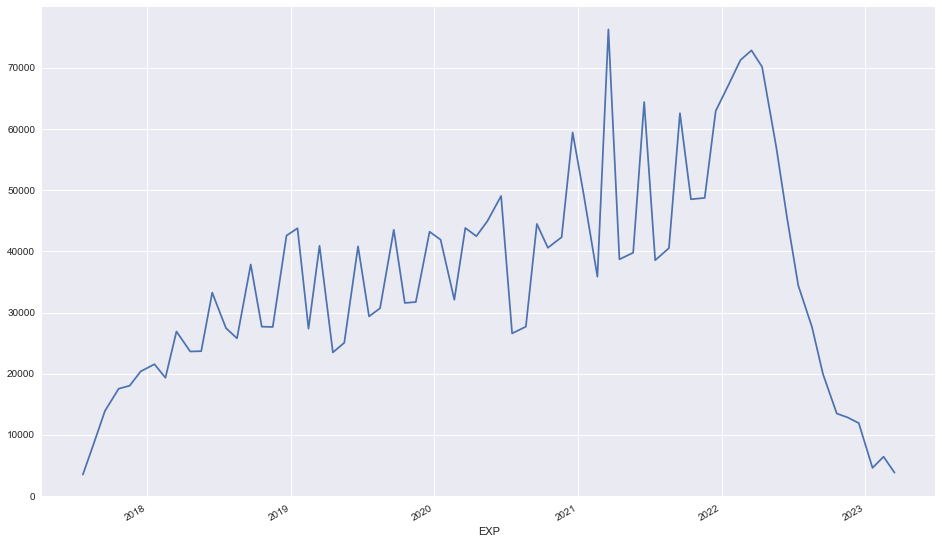

In [8]:
base_data.groupby('EXP').count()['TS'].plot()

In [9]:
# enrich basic feature
ATM_vols = base_data[base_data["RANK"]==0]
base_data = pd.merge(base_data, ATM_vols[["TS", "TYPE", "IV_BID", "IV_ASK"]], left_on=["TS", "TYPE"], right_on=["TS", "TYPE"], 
              suffixes=(None, "_ATM"), how="left")
base_data["MONEYNESS"] = base_data["UNDERLYING_PRICE"] - base_data["STRIKE"]

base_data["MONEYNESS_F"] = base_data["STRIKE"]/base_data["F_T"]
base_data["LOG_MONEYNESS_F"] = np.log(base_data["MONEYNESS_F"])
base_data["LOG_MONEYNESS_F_STANDARD_TIME"] = base_data["LOG_MONEYNESS_F"] / np.sqrt(base_data["CAL_DAYS"])

# df["LOG_MONEYNESS_F_STANDARD_STD"] = df["LOG_MONEYNESS_F"] / (np.sqrt(df["CAL_DAYS"])*(df["IV_BID_ATM"]+df["IV_ASK_ATM"])/2)

base_data["IV_BID_DIFF"] = base_data["IV_BID"] - base_data["IV_BID_ATM"]
base_data["IV_ASK_DIFF"] = base_data["IV_ASK"] - base_data["IV_ASK_ATM"]

base_data["IV_BID_RATIO"] = base_data["IV_BID"]/base_data["IV_BID_ATM"]
base_data["IV_ASK_RATIO"] = base_data["IV_ASK"]/base_data["IV_ASK_ATM"]
base_data

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IV_BID_ATM,IV_ASK_ATM,MONEYNESS,MONEYNESS_F,LOG_MONEYNESS_F,LOG_MONEYNESS_F_STANDARD_TIME,IV_BID_DIFF,IV_ASK_DIFF,IV_BID_RATIO,IV_ASK_RATIO
0,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.0823,0.0882,-0.99,1.0014,0.0014,0.0003,0.0000,0.0000,1.0000,1.0000
1,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.0871,0.0908,-0.99,1.0014,0.0014,0.0003,-0.0048,-0.0026,0.9448,0.9714
2,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.0950,0.0980,-0.99,1.0014,0.0014,0.0003,-0.0128,-0.0098,0.8658,0.9001
3,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.1067,0.1097,-0.99,1.0014,0.0014,0.0003,-0.0244,-0.0215,0.7709,0.8039
4,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.1167,0.1196,-0.99,1.0014,0.0014,0.0003,-0.0344,-0.0314,0.7049,0.7373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25136353,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.2006,0.2172,-869.59,1.1822,0.1674,0.0089,-0.0575,-0.0589,0.7131,0.7288
25136354,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.2025,0.2175,-869.59,1.1822,0.1674,0.0089,-0.0595,-0.0592,0.7064,0.7277
25136355,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.1971,0.2186,-869.59,1.1822,0.1674,0.0089,-0.0540,-0.0603,0.7259,0.7242
25136356,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.1963,0.2275,-869.59,1.1822,0.1674,0.0089,-0.0533,-0.0692,0.7287,0.6959


In [13]:
full_data = base_data.merge(raw_data,how='left', on=['TS','EXP','STRIKE','TYPE','BID_CLOSE','ASK_CLOSE','VOLUME','OPEN_INT','UNDERLYING_PRICE'])
full_data

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IV_BID_ATM,IV_ASK_ATM,MONEYNESS,MONEYNESS_F,LOG_MONEYNESS_F,LOG_MONEYNESS_F_STANDARD_TIME,IV_BID_DIFF,IV_ASK_DIFF,IV_BID_RATIO,IV_ASK_RATIO,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA,PRICE
0,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.0823,0.0882,-0.99,1.0014,0.0014,0.0003,0.0000,0.0000,1.0000,1.0000,0.0730,0.5085,0.0103,-0.4882,2.1112,2429.01
1,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.0871,0.0908,-0.99,1.0014,0.0014,0.0003,-0.0048,-0.0026,0.9448,0.9714,0.0730,0.5085,0.0103,-0.4882,2.1112,2429.01
2,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.0950,0.0980,-0.99,1.0014,0.0014,0.0003,-0.0128,-0.0098,0.8658,0.9001,0.0730,0.5085,0.0103,-0.4882,2.1112,2429.01
3,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.1067,0.1097,-0.99,1.0014,0.0014,0.0003,-0.0244,-0.0215,0.7709,0.8039,0.0730,0.5085,0.0103,-0.4882,2.1112,2429.01
4,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.1167,0.1196,-0.99,1.0014,0.0014,0.0003,-0.0344,-0.0314,0.7049,0.7373,0.0730,0.5085,0.0103,-0.4882,2.1112,2429.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25136353,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.2006,0.2172,-869.59,1.1822,0.1674,0.0089,-0.0575,-0.0589,0.7131,0.7288,0.0994,-0.9581,0.0002,-0.0335,3.8816,4530.41
25136354,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.2025,0.2175,-869.59,1.1822,0.1674,0.0089,-0.0595,-0.0592,0.7064,0.7277,0.0994,-0.9581,0.0002,-0.0335,3.8816,4530.41
25136355,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.1971,0.2186,-869.59,1.1822,0.1674,0.0089,-0.0540,-0.0603,0.7259,0.7242,0.0994,-0.9581,0.0002,-0.0335,3.8816,4530.41
25136356,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.1963,0.2275,-869.59,1.1822,0.1674,0.0089,-0.0533,-0.0692,0.7287,0.6959,0.0994,-0.9581,0.0002,-0.0335,3.8816,4530.41


In [15]:
full_data=full_data.dropna().reset_index(drop=True)
target = full_data[(full_data["EXP"]=="2017-12-15")&(full_data["BUS_DAYS"] < 126)]
target

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IV_BID_ATM,IV_ASK_ATM,MONEYNESS,MONEYNESS_F,LOG_MONEYNESS_F,LOG_MONEYNESS_F_STANDARD_TIME,IV_BID_DIFF,IV_ASK_DIFF,IV_BID_RATIO,IV_ASK_RATIO,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA,PRICE
299225,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.0823,0.0882,4.01,1.0013,0.0013,0.0001,0.0344,0.0314,1.4186,1.3563,0.0878,0.5625,0.0028,-0.2181,6.422,2429.01
299226,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.0871,0.0908,4.01,1.0013,0.0013,0.0001,0.0296,0.0288,1.3403,1.3175,0.0878,0.5625,0.0028,-0.2181,6.422,2429.01
299227,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.0950,0.0980,4.01,1.0013,0.0013,0.0001,0.0217,0.0216,1.2282,1.2208,0.0878,0.5625,0.0028,-0.2181,6.422,2429.01
299228,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.1067,0.1097,4.01,1.0013,0.0013,0.0001,0.0100,0.0099,1.0936,1.0903,0.0878,0.5625,0.0028,-0.2181,6.422,2429.01
299229,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.1167,0.1196,4.01,1.0013,0.0013,0.0001,0.0000,0.0000,1.0000,1.0000,0.0878,0.5625,0.0028,-0.2181,6.422,2429.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404622,2017-12-14,2017-12-15,2520,P,0.1,0.175,0.25,41,9726,2652.06,132.06,52,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3271,0.3495,0.3659,0.0961,0.0993,132.06,0.9494,-0.0519,-0.0519,0.2310,0.2666,3.4042,3.6837,0.1294,0.0000,0.0000,0.0000,0.000,2652.06
404623,2017-12-14,2017-12-15,2520,P,0.1,0.175,0.25,41,9726,2652.06,132.06,52,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3271,0.3495,0.3659,0.1147,0.1174,132.06,0.9494,-0.0519,-0.0519,0.2124,0.2485,2.8518,3.1170,0.1294,0.0000,0.0000,0.0000,0.000,2652.06
404624,2017-12-14,2017-12-15,2520,P,0.1,0.175,0.25,41,9726,2652.06,132.06,52,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3271,0.3495,0.3659,0.1263,0.1296,132.06,0.9494,-0.0519,-0.0519,0.2008,0.2364,2.5899,2.8241,0.1294,0.0000,0.0000,0.0000,0.000,2652.06
404625,2017-12-14,2017-12-15,2520,P,0.1,0.175,0.25,41,9726,2652.06,132.06,52,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3271,0.3495,0.3659,0.1339,0.1395,132.06,0.9494,-0.0519,-0.0519,0.1932,0.2265,2.4426,2.6240,0.1294,0.0000,0.0000,0.0000,0.000,2652.06


In [16]:
target.to_csv("2017-12-15_base_data.csv",index=False)

In [18]:
target.drop_duplicates()

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IV_BID_ATM,IV_ASK_ATM,MONEYNESS,MONEYNESS_F,LOG_MONEYNESS_F,LOG_MONEYNESS_F_STANDARD_TIME,IV_BID_DIFF,IV_ASK_DIFF,IV_BID_RATIO,IV_ASK_RATIO,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA,PRICE
299225,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.0823,0.0882,4.01,1.0013,0.0013,0.0001,0.0344,0.0314,1.4186,1.3563,0.0878,0.5625,0.0028,-0.2181,6.422,2429.01
299226,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.0871,0.0908,4.01,1.0013,0.0013,0.0001,0.0296,0.0288,1.3403,1.3175,0.0878,0.5625,0.0028,-0.2181,6.422,2429.01
299227,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.0950,0.0980,4.01,1.0013,0.0013,0.0001,0.0217,0.0216,1.2282,1.2208,0.0878,0.5625,0.0028,-0.2181,6.422,2429.01
299228,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.1067,0.1097,4.01,1.0013,0.0013,0.0001,0.0100,0.0099,1.0936,1.0903,0.0878,0.5625,0.0028,-0.2181,6.422,2429.01
299229,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.1167,0.1196,4.01,1.0013,0.0013,0.0001,0.0000,0.0000,1.0000,1.0000,0.0878,0.5625,0.0028,-0.2181,6.422,2429.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404622,2017-12-14,2017-12-15,2520,P,0.1,0.175,0.25,41,9726,2652.06,132.06,52,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3271,0.3495,0.3659,0.0961,0.0993,132.06,0.9494,-0.0519,-0.0519,0.2310,0.2666,3.4042,3.6837,0.1294,0.0000,0.0000,0.0000,0.000,2652.06
404623,2017-12-14,2017-12-15,2520,P,0.1,0.175,0.25,41,9726,2652.06,132.06,52,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3271,0.3495,0.3659,0.1147,0.1174,132.06,0.9494,-0.0519,-0.0519,0.2124,0.2485,2.8518,3.1170,0.1294,0.0000,0.0000,0.0000,0.000,2652.06
404624,2017-12-14,2017-12-15,2520,P,0.1,0.175,0.25,41,9726,2652.06,132.06,52,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3271,0.3495,0.3659,0.1263,0.1296,132.06,0.9494,-0.0519,-0.0519,0.2008,0.2364,2.5899,2.8241,0.1294,0.0000,0.0000,0.0000,0.000,2652.06
404625,2017-12-14,2017-12-15,2520,P,0.1,0.175,0.25,41,9726,2652.06,132.06,52,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3271,0.3495,0.3659,0.1339,0.1395,132.06,0.9494,-0.0519,-0.0519,0.1932,0.2265,2.4426,2.6240,0.1294,0.0000,0.0000,0.0000,0.000,2652.06


In [11]:
# save the above processed base_data, we can directly use this in the next time.
# but csv file is large
base_data.to_csv("snp_base_data.csv",index=False)
# base_data = pd.read_csv("snp_base_data.csv")

#### * Question 1: should we calculate the greeks for every option as features?

# 2.vol curve fit
* hyperbola for example, maybe expand more model in future

Fixed a specific expiration, we can fit a set of vol curves(different DTE), x axis is moneyness, y axis is iv. \
When fitting the curve, we use out-of-the-money data to fit vol curve.


[Hyperbola Equation](https://www.desmos.com/calculator/phvqct3f4b):

$$\begin{aligned}
    y &= \sqrt{b^{2}\left(1+\frac{\left(x-c\right)^{2}}{a^{2}}\right)}+d(x-c) + e
\end{aligned}$$


#### * Question 2: the intuitively financial meaning of a,b,c,d,e?

In [ ]:
def hyperbola(x, a, b, c, d, e) -> float:
    """Tiltable hyperbola for scipy.optimize.curve_fit
    Asymptotes at 
    y=(-b/a+d)(x-c)+e
    y=( b/a+d)(x-c)+e"""
    return (b**2*(1+(x-c)**2/a**2))**0.5+d*(x-c)+e

def hyperbola_jac(x, a, b, c, d, e) -> np.ndarray:
    """Jacobian of the hyperbola with respect to each parameter"""
    ru = np.sqrt(b**2*(1+(x-c)**2/a**2))
    da = -(b**2 * (x-c)**2) / (a**3 * ru)
    db = np.sqrt(1+(x-c)**2/a**2)
    dc = -(b**2 * (x-c)) / (a**2 * ru) - d
    dd = x-c
    de = np.ones(len(x))
    return np.array([da, db, dc, dd, de]).T

def hyperbola_minimizer(a, b, c, d, e) -> float:
    """Returns the minimizer (x such that y is the minimum) of a hyperbola"""
    return ((a**2 * c * d**2 + d*(a**4 * b**2 - a**6 * d**2)**0.5 - b**2 * c)
            /(a**2 * d**2 - b**2))

def fit_hyp(df) -> np.ndarray:
    """Fits a hyperbola for a day's IV single curve"""
    curve = df.dropna()
    bounds = ((1e-4, 1e-4, 0, -2, -2), (1, 1, 1, 2, 2))
    popt, pcov = curve_fit(hyperbola, curve["LOG_MONEYNESS_F"], curve["IV_MID"]**2, 
                           jac=hyperbola_jac, bounds=bounds)
    return popt


* Need to do: for every expiration, generating the set of hyperbola parameters, which are the base/real data for prediction in the following parts.

* Ideal real dataset dimension: T* t* 5, T:expirations t:dte 5:param(a,b,c,d,e)

#### * Question 3: how to deal overlap vol curves on the same date, but fitted from different expiration?

# 3.vol curve models evaluation
loss function/evaluation standard:

$$\begin{aligned}
    ((iv_{mid} - iv_{fitted})*(vega+C))^2
\end{aligned}$$

We want to predict the best vol curve parameters in the following parts.

# 4. parameter prediction

If we can link the parameters in different expirations, then the base data is a T*5 time series matrix, then we utilize various ways to predict this data.

* evaluation standard: Pearson Correlation

## 4.1 multiple time series prediction on parameters
* ARMA, VARMA, GARCH, Kalman Enhancer, LSTM, LightGBM, ...

<AxesSubplot:>

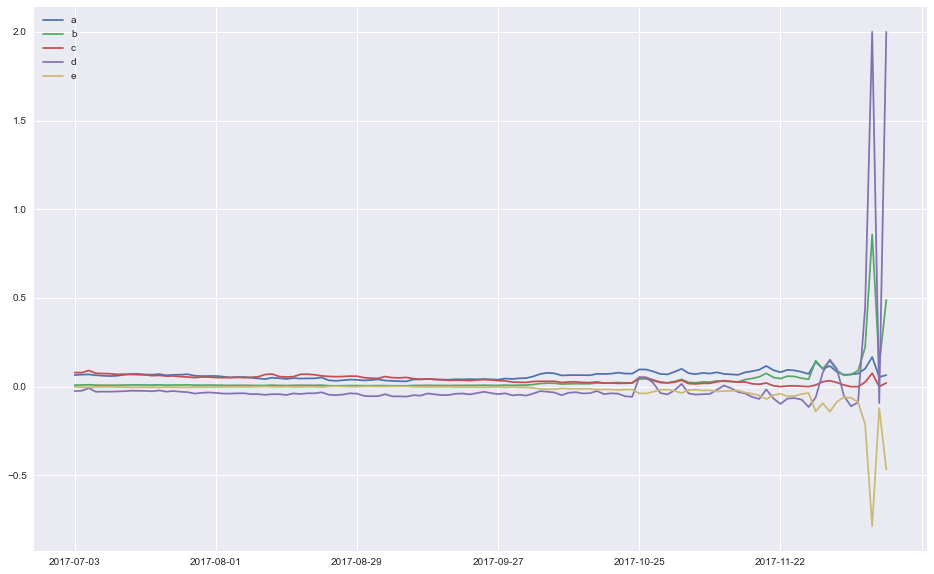

In [34]:
base_df = pd.read_csv("a_e.csv",index_col=0)
fit_df = base_df.shift(1)
base_df.plot()

<AxesSubplot:>

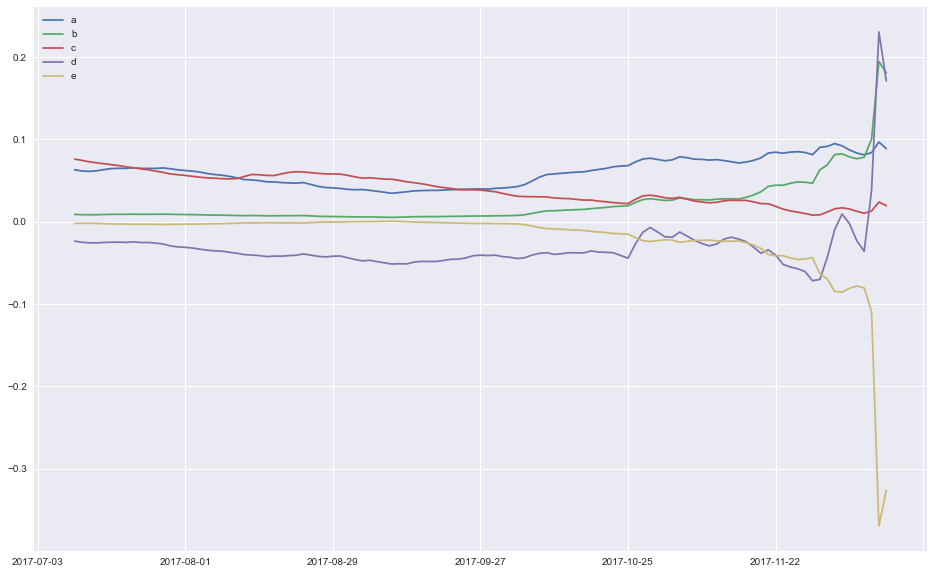

In [33]:
duration = 10
min_period = 5
signal_df = np.log(1 + fit_df).ewm(
            span=duration, min_periods=min(duration, min_period)).mean()
signal_df.plot()

In [36]:
import cv2
n = 10  # 状态矩阵维数
# 创建kalman滤波器 dynam_params：状态空间的维数；measure_param：测量值的维数
kalman = cv2.KalmanFilter(n, 5)
# 设置测量矩阵 H
kalman.measurementMatrix = np.array(np.eye(5, n), np.float32)
# 设置转移矩阵 F
kalman.transitionMatrix = np.array(np.eye(n), np.float32)
# 设置过程噪声协方差矩阵 Q
kalman.processNoiseCov = np.array(np.eye(n) * 0.03, np.float32)

df = fit_df
signal_df = pd.DataFrame(index=df.index, columns=df.columns)
for i in range(0, len(df)):
    current_measurement = np.array(
        df.iloc[i, :].values, np.float32).reshape(5, 1)
    kalman.correct(current_measurement)  # 用当前测量来校正kalman滤波器
    current_prediction = kalman.predict()  # predict状态的预测值矩阵
    y = kalman.measurementMatrix.dot(current_prediction)  # 根据状态值的
    signal_df.iloc[i, :] = y.T

## 4.2 build cross-sectional features for prediction

## 4.3 merge features together(feature engineering)
* OLS, Trees, Neural Network, Reinforce Learning, ...

In [12]:
12+0.42*(0.95+1.15)

12.882

In [14]:
np.sqrt(0.12**2+0.42**2*(0.0115**2+0.0095**2))

0.12016342621613284

In [15]:
np.sqrt(0.42**2*(0.0115**2+0.0095**2))

0.006264902233874044

In [21]:
(np.exp((1.3-4.8)/100*181/360)-1)*0.9307

-0.016234474958984006

In [23]:
0.9305*((1+1.3/100*181/360)/(1+4.8/100*181/360)-1)

-0.015988362789133344

In [25]:
((1+4.55/100*92/360)*9.8195/9.858-1)*360/92

0.03004007669780402

In [27]:
0.9322*((1+1.3/100*182/360)/(1+4.85/100*182/360))-0.9322*((1+1.15/100*91/360)/(1+4.6/100*91/360))

-0.008293879443290186